# Qiskit で量子コンピュータの実機を動かしてみる

- author: "Tsubasa Kanai"
- toc: true 
- badges: true
- comments: true
- categories: [jupyter, qiskit]

## はじめに
今回は [IBM Quantum](https://quantum-computing.ibm.com/) が提供している実機を動かしてみようと思います。
IBM Quantum では現在、無料アカウントを作れば 5 qubit (量子ビット) までの実機を走らせることができます。
どんな実機があるかは[ここ](https://quantum-computing.ibm.com/services?services=systems)で確認できます。
鍵マークのついていないものが無料アカウントでも使えるものですね。
ibmq_brooklyn や ibmq_manhattan の 65 qubit というのが現在の最大のようです。[IBM Quantum Network](https://www.ibm.com/quantum-computing/network/members/) という有償サービス？に入ればそれらも使えるようです。主に大学などの研究機関や企業が参加してるようです。

## 準備
[IBM Quantum](https://quantum-computing.ibm.com/) にアクセスして Web から動かすのは簡単ですが、僕は local 環境から Python を使って動かしたいので、[前回準備した](https://qosajin.github.io/qosamu-pages/jupyter/conda/qiskit/2021/08/31/qiskit-local-installation.html#Version-情報) local 環境で Jupyter Notebook を立ち上げて動かしてみます。

その前に、実機のアクセスには API token が必要なので、[IBM Quantum の dashboard ページ](https://quantum-computing.ibm.com/) にアクセスし、コピーしておきます。
![](tsubasa-cc_images/api-token.png)

## 量子回路の作成
実機で動かしたい量子回路 (Quantum Circuit) を作成します。ここは実機の場合もシミュレータの場合も同様なので、前回使ったのと同じ回路を作っておきます。2量子ビットを使い、片方に Hadamard gate をかけ、その後 control-NOT gate をかけて両方の量子ビットを測定するだけの回路です。前回のシミューレータの結果からわかる通りこれは $|00>$ と $|11>$ という2つの状態の重ね合わせで、それぞれの量子ビットの内積で表現できないので (それぞれの量子ビットが互いに依存しているので) 「量子もつれ」と言われる状態です。

最近知ったのですが、circuit を draw するときに 'mpl' (matplotlib) という引数を入れて実行すると、text ではなくちょっとかっこいい image 形式で量子回路を出力できます。

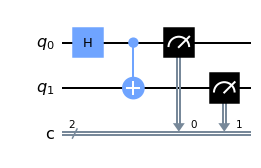

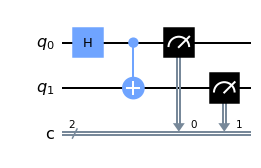

In [1]:
from qiskit import *
# from qiskit.visualization import plot_histogram

circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure([0,1], [0,1])
circuit.draw('mpl')

## 実機へのアクセス
量子回路を準備したら、実機へのアクセスをしてみます。
以下では、上でコピーした API token を mytoken という変数に入れ、それを使って save_acount を実行しています。

In [2]:
from getpass import getpass
mytoken = getpass(prompt = 'My Token: ')
IBMQ.save_account(token=mytoken)

My Token: ········


そうすると、local Mac 上に ~/.qiskit/qiskitrc というファイルが作成され、token が保存されます。この save_acount は token が変わったり、PC/Mac が変わらない限り一度実行しておけば OK です。
```
$ cat ~/.qiskit/qiskitrc
[ibmq]
token = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
url = https://auth.quantum-computing.ibm.com/api
verify = True
```

アカウントの準備ができたら使用可能な実機を探します。IBMQ.load_acount で IBMQ にログインし、IBMQ.get_provider("ibm-q") で ibm-q の provider (実機) の情報？を取得します。
[Qiskit textbook](https://qiskit.org/textbook/preface.html) でよく出てくる方法ですが、その後、least_busy という関数を使って条件に合う実機のうち、最も暇な (queue に入ってる job の少ない) 実機を見つけます。
ここでは3つの条件を指定してます。
- x.configuration().n_qubits >= 2: 量子ビットの数が2以上
- x.configuration().simulator: シミュレータじゃない (= 実機)
- x.status().operational==True: 今動いてる奴

In [6]:
from qiskit.providers.ibmq import least_busy
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", backend)

Running on current least busy device:  ibmq_quito


これを実行した時点では ibmq_quito というのが一番暇だったようなので、これを使います！
qiskit.providers.ibmq.jupyter という module を import して backend device 情報を見ると、GUI でカチカチと実機情報 (量子ビット数とか、エラーの大きさとか、) を見れます！
![](tsubasa-cc_images/backend_ibmq_quito.png)

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

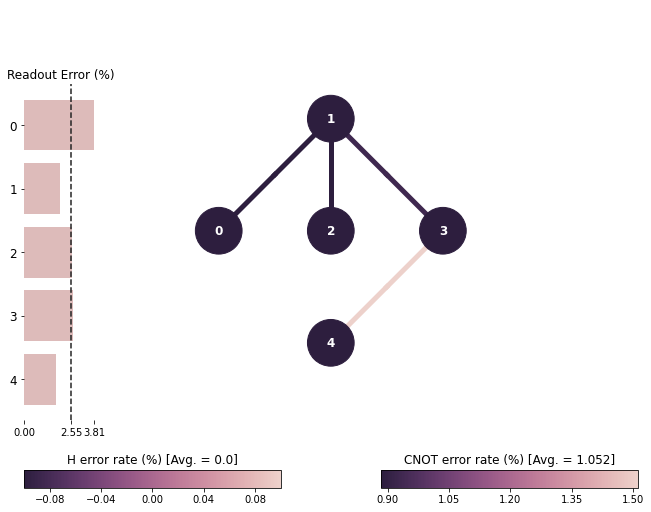

In [15]:
import qiskit.providers.ibmq.jupyter
backend

## 実機を走らせる！
ここまで来たらあとは走らせて結果を見ます。execute で quantum circuit, backend, shots (試行回数) を指定して実機を動かします。
実機動作の状況は job_monitor を実行しておくと逐一確認ができて、"Job Status: job has successfully run" と出てきたら完了です！

In [11]:
from qiskit.tools.monitor import job_monitor
job = execute(circuit, backend, shots=8192)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
結果を見てみます。実機を走らせた後のデータの処理方法はシミュレータの場合と同様です。

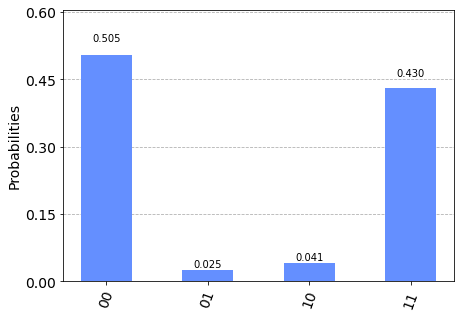

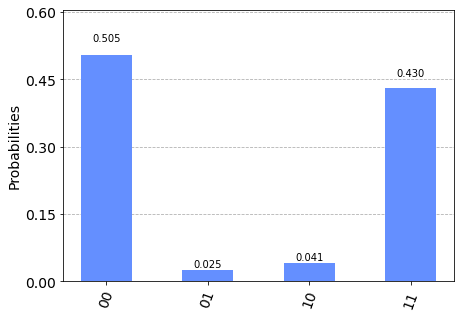

In [13]:
from qiskit.visualization import plot_histogram
counts = job.result().get_counts()
plot_histogram(counts)

シミュレータでは期待された $|00>$ と $|11>$ の状態がそれぞれ約50%の確率で発生しているのがばっちり見えましたが、実機の場合はそれ以外の '01' や '10' という結果も数%ずつ入ってしまいました。これは実機特有のエラーが原因です。この辺りのエラーも定量的に検証できると面白そうだな、と思っています。
今回はここまで！

## Version 情報

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table